# Fundamentos de analítica 2 (taller 3) ARIMA #

Realizado por:
- Alfredo Aponte 
- Álvaro Rodríguez

 Universidad ICESI

# **1. Carga de paquetes**

In [1]:
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
# Comentarios al final

# **2. Carga de datos**

Se cargan los datos, con la información de los empleados Ocupados

In [2]:
data = pd.read_excel("datosEmpleo.xlsx")
data.head()

,mes,TD_13ciudades,Ocupados,Desocupados,Inactivos
0,2001-01-01,20.946380,6923.604,1834.507,4600.718
1,2001-02-01,19.894213,7037.746,1747.820,4596.805
2,2001-03-01,19.221565,6945.973,1652.823,4807.120
3,2001-04-01,17.888575,6973.079,1519.137,4937.280
4,2001-05-01,17.945654,6994.462,1529.720,4928.911


# **3. Ejecucion del modelo con los datos originales**

### 3.1 Protocolo evaluación, split (hold-out) para datos originales

In [8]:
#Dividir los datos en conjuntos de entrenamiento y de prueba.
y = data["Ocupados"] #Crear variable y con la columna ocupados
breakpoint( ) #Pausa para ver la variable y
breakpoint()
X = pd.DataFrame(data.index)
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]
y_test

214    10783.299
215    10835.398
216    10314.438
217    10557.917
218    10760.776
219    10632.028
Name: Ocupados, dtype: float64

### 3.2 ACF y PACF

ACF (Auto-Correlation Function) y PACF (Partial Auto-Correlation Function) son herramientas estadísticas utilizadas para analizar series temporales. Aquí te explico cada una:


ACF (Auto-Correlation Function):

Definición: La ACF mide la correlación entre una serie temporal y una versión rezagada de sí misma. Es decir, compara el valor en el tiempo
𝑡
t con los valores en el tiempo
𝑡
−
𝑘
t−k, donde
𝑘
k es el rezago.
Propósito: Ayuda a identificar patrones de repetición en la serie temporal, como estacionalidad o ciclos. También es útil para determinar el orden de un modelo ARIMA (Auto-Regressive Integrated Moving Average), observando los rezagos donde la correlación es significativa.
Interpretación: En un gráfico de ACF, si hay barras significativas en ciertos rezagos, esto indica que hay una correlación persistente entre los valores en esos rezagos y el valor actual. Para procesos ARMA, la ACF tiende a decaer gradualmente.


PACF (Partial Auto-Correlation Function):

Definición: La PACF mide la correlación entre una serie temporal y una versión rezagada de sí misma, eliminando los efectos de las correlaciones en los rezagos intermedios. En otras palabras, la PACF muestra la relación directa entre los valores en el tiempo
𝑡
t y en el tiempo
𝑡
−
𝑘
t−k, descontando los efectos de los rezagos intermedios.
Propósito: Se utiliza para identificar el número de términos autorregresivos (AR) en un modelo ARIMA. El PACF indica cuántos rezagos de la serie tienen una correlación significativa después de ajustar por la influencia de otros rezagos.
Interpretación: En un gráfico de PACF, si solo los primeros rezagos tienen correlaciones significativas, esto sugiere que el modelo AR debería tener un número de términos igual al número de rezagos significativos en la PACF. Para procesos AR, la PACF generalmente muestra un corte claro después de un cierto rezago.
En resumen, ACF y PACF son fundamentales para el análisis de series temporales, ayudando a identificar la estructura subyacente y a determinar los parámetros apropiados para modelos predictivos.

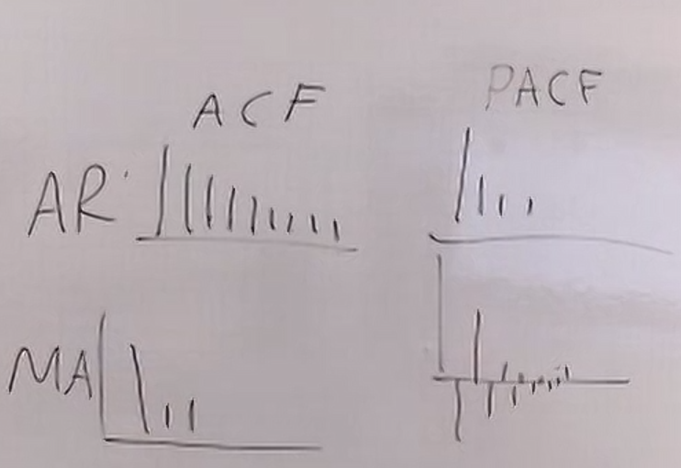

In [4]:
# Calcula la función de autocorrelación (ACF) de los datos y_train hasta un desfase de 40.
acf(y_train,40)


array([1.        , 0.97791615, 0.96080801, 0.94667826, 0.93331952,
       0.92246288, 0.90890425, 0.89895712, 0.88616889, 0.87708222,
       0.87157593, 0.86626345, 0.86077083, 0.84142836, 0.82399124,
       0.8082148 , 0.79697724, 0.78604389, 0.77291991, 0.76236066,
       0.74958796, 0.73837173, 0.73113649, 0.72434815, 0.7167177 ,
       0.69754163, 0.67796414, 0.66216212, 0.64826997, 0.63651197,
       0.62190178, 0.60943523, 0.59693407, 0.58423665, 0.57711519,
       0.57028981, 0.5606386 , 0.53938066, 0.52087047, 0.50524286,
       0.49022537])

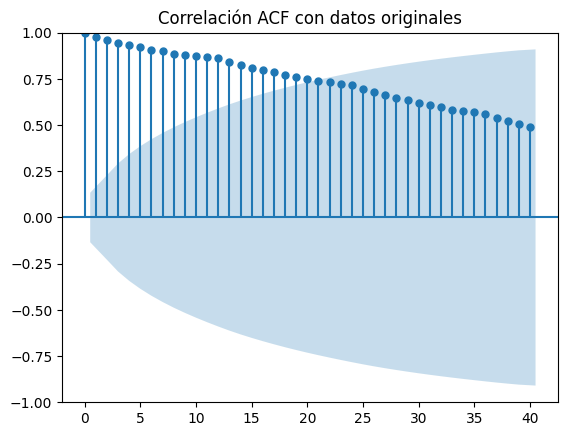

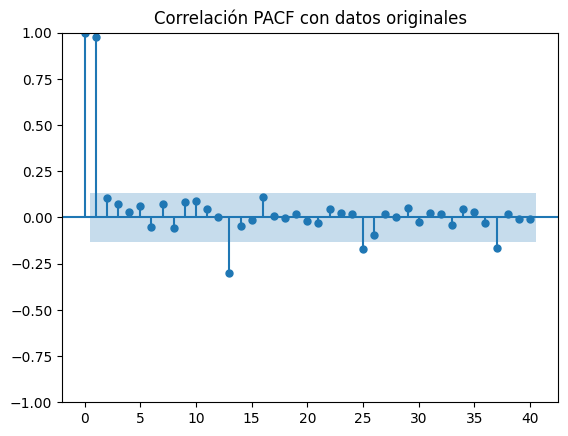

In [5]:
# Trace la función de autocorrelación (ACF) para los datos de la serie temporal dada.
plot_acf(y_train,lags=40, title = "Correlación ACF con datos originales");
plot_pacf(y_train,lags=40, title = "Correlación PACF con datos originales");

Al combinar el análisis del gráfico ACF con el del gráfico PACF anterior, se podría concluir que la serie tiene un componente AR significativo, posiblemente de orden 1 (AR(1)), y quizás también un componente de media móvil (MA), lo cual debería confirmarse con un análisis adicional o pruebas estadísticas.

### 3.3 Autoarima (escogencia mejor modelo)

1.	p - Orden de la parte autorregresiva (AR): Este parámetro indica el número de términos autorregresivos que se incluyen en el modelo. Esencialmente, captura la influencia de los valores pasados de la serie temporal en el valor actual. En un modelo ARIMA, el componente AR se expresa como una suma ponderada de los valores pasados.
2.	d- Orden de diferenciación (I): Este parámetro representa el número de veces que se diferencia la serie temporal para hacerla estacionaria. La diferenciación es el proceso de restar el valor actual de un valor pasado (o de aplicar la diferenciación más veces si ddd es mayor de 1). La diferenciación se utiliza para eliminar tendencias y estacionalidades, haciendo que la serie sea más adecuada para modelar.
3.	q - Orden de la parte de media móvil (MA): Este parámetro define el número de términos de media móvil que se incluyen en el modelo. Captura el efecto de los errores pasados en el valor actual. En la parte MA del modelo, se usan los errores residuales (diferencias entre los valores observados y los valores predichos) de periodos anteriores para modelar el comportamiento de la serie temporal.


In [6]:
#Esta línea de código utiliza la función auto_arima para seleccionar automáticamente el mejor modelo ARIMA para 
# los datos de la serie temporal y_train
model = auto_arima(y_train, max_p=100, max_q=100, information_criterion="aic") # Ideal 10, arima generally gives 1 to 3
#Pregunta: ¿por qué no usó max "d"?


In [7]:

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Fri, 23 Aug 2024   AIC                           2800.549
Time:                        23:39:53   BIC                           2813.994
Sample:                             0   HQIC                          2805.983
                                - 214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3398      2.394      4.320      0.000       5.648      15.031
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      0.048    -18.169      0.0

El modelo probao es un ARIMA(1, 1, 1), lo que nos indica que se tiene en cuenta una relación entre el valor actual de la serie y su valor en el tiempo pasado (AR), corrigiendo cualquier tendencia a largo plazo (I), teniendo en cuenta el impacto de errores pasados (MA).

La prueba de Ljung-Box sugiere que no hay autocorrelación en los residuos.

Sin embargo, la prueba de Jarque-Bera indica que los residuos podrían no ser normales, lo que podría afectar la interpretación de los intervalos de confianza y las predicciones.

Como parte de las limitaciones, encontramos que los gráficos representan una realidad parcial del modelo autoarima, pues la interpretación del gráfico Vs. el modeolo, no es concluyente.

**Sería prudente realizar transformaciones adicionales o ajustar un modelo diferente para abordar la no normalidad observada en los residuos.**

#### 3.3.1. Ejecutar predicciones

In [8]:
h = 6 #Ventana
y_pred = model.predict(h) #Ejecutar predicciones
y_pred

214    10918.120046
215    10947.966731
216    10971.604570
217    10992.476082
218    11012.115068
219    11031.204907
dtype: float64

#### 3.3.2. Calculo del RSME

In [9]:
#Calculo del error cuadrático medio (RMSE) de las predicciones de un modelo.
rmse_arima= np.sqrt(mean_squared_error(y_test, y_pred))
print("RSME para modelo Arima: ", rmse_arima)

RSME para modelo Arima:  381.67863024707736


#### 3.3.4. Cálculo de residuales

In [10]:
# Calculo de los residuos restando los valores predichos y_pred de los valores reales y_test. 
# La matriz resultante resid_pred contendrá las diferencias entre los valores reales y los valores predichos 
# para cada punto de datos correspondiente.

resid_pred = y_test - y_pred
resid_pred

214   -134.821046
215   -112.568731
216   -657.166570
217   -434.559082
218   -251.339068
219   -399.176907
dtype: float64

In [11]:
resid_full = pd.concat([model.resid() , resid_pred]) # Use pd.concat to combine the two Series
resid_full = resid_full.iloc[1:]
resid_full

1      157.871834
2      -40.469855
3       26.666517
4       20.251497
5       16.366047
          ...    
215   -112.568731
216   -657.166570
217   -434.559082
218   -251.339068
219   -399.176907
Length: 219, dtype: float64

### 3.4. Validación de supuestos del modelo

#### 3.4.1 Validación de Residuales

Text(0.5, 1.0, 'Residuos del modelo')

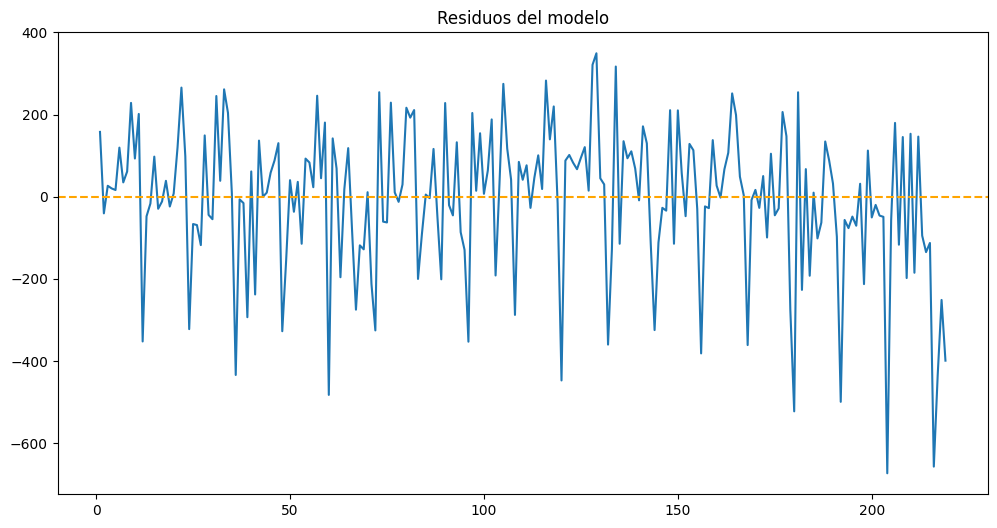

In [12]:
fig = plt.figure(figsize=(12, 6))
plt.plot(resid_full,label="Residuales",)
plt.axhline(y=0, color='orange', linestyle='--')
plt.title('Residuos del modelo')

Anlizando el gráfico de los residuales, no se observa un patrón aleatorio en los mismos, evidenciando una posible tendencia y heterocedasticidad. Se observan algunos picos y valles bastante pronunciados que sugieren que, en ciertos momentos, el modelo se aleja considerablemente de las observaciones reales.

####  3.4.2 Validación del supuesto de NO Autocorrelación

##### 3.4.2.1 Prueba de rachas

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [13]:
residuales = resid_full

In [14]:
signo = residuales >0

In [15]:
runstest_1samp(signo, correction=False)

(-1.3206557173529276, 0.18661618569086624)

El segundo valor corresponde al p-valor superior al nivel de significancia, por lo tanto considerando un $α$=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie parece comportarse como un ruido blanco, **No presenta autocorrelación**.

##### 3.4.2.2 Prueba de Box Pierce y Ljung-Box

Este análisis debe complementarse con otras pruebas como la prueba de Box-Pierce y la modificación de Ljung-Box para muestras pequeñas.

In [16]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(residuales, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.14862,0.142698,2.119453,0.145438


Con el resultado anterior no rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión Es probar por lo menos los primeros 20 rezagos.

In [17]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuales, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,2.148620,1.426981e-01,2.119453,1.454384e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,2.735348,2.546987e-01,2.695562,2.598162e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,2.799919,4.235133e-01,2.758672,4.303486e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,3.185827,5.272231e-01,3.134103,5.356397e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,3.929129,5.596641e-01,3.853861,5.706425e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,5.120908,5.284021e-01,5.002499,5.434927e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,5.855468,5.567236e-01,5.707144,5.743300e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,6.945523,5.425216e-01,6.747876,5.640633e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,7.463898,5.889379e-01,7.240450,6.121008e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,8.613444,5.691391e-01,8.327577,5.968731e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


El análisis de 20 rezagos, no es concluyente respecto a la "No autocorrelación" de los residuales.  La proporción entre rechazar o no la hipótesis nula, es 50/50

#### 3.4.3 Validación del supuesto de homocedasticidad

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

H0:  Comportamiento Homoscedastico (Es decir varianza constante)

H1:  Comportamiento Heteroscedastico (Es decir varianza no constante)

In [18]:
sm.stats.acorr_ljungbox((residuales-residuales.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.513298,4.737146e-01,0.506330,4.767318e-01
2,0.514075,7.733392e-01,0.507093,7.760436e-01
3,1.102827,7.763916e-01,1.082525,7.812941e-01
4,2.400054,6.626175e-01,2.344533,6.726733e-01
5,3.480713,6.263080e-01,3.390963,6.399466e-01
6,3.602380,7.303024e-01,3.508226,7.428750e-01
7,4.925661,6.690348e-01,4.777618,6.870802e-01
8,5.338943,7.208109e-01,5.172199,7.390227e-01
9,5.657302,7.736662e-01,5.474712,7.911204e-01
10,6.741906,7.495653e-01,6.500423,7.716153e-01


Los resultados del la tabla anterior, no son concluyentes, respecto a rechazar on o la hipótesis nula de un comportamiento homocedástico(no auto-correlación de las varianzas).  No se puede concluir por tanto si existe o no tanto comportamiento ARCH o GARCH o heterocedástico.

#### 3.4.4  Normalidad

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Nótese que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

#### 3.4.4.1 QQ Plot

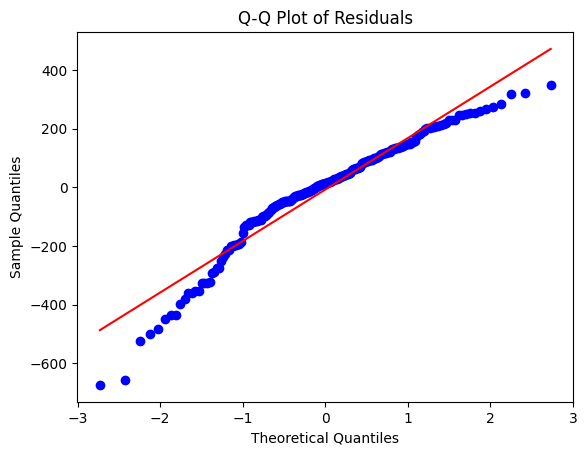

In [19]:
stats.probplot(residuales, dist="norm", plot=plt)
# Añadir etiquetas y título (opcional)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
# Mostrar el gráfico
plt.show()

#### 3.4.4.2 Histograma de residuales

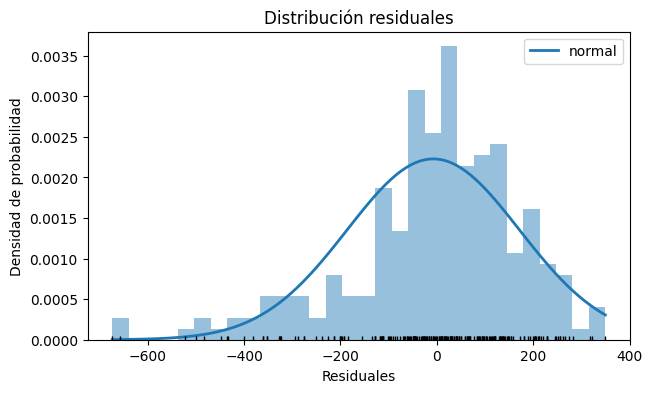

In [20]:
# Histograma + curva normal teórica
# ==============================================================================
# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(residuales)
# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(residuales), max(residuales), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)
# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=residuales, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(residuales, np.full_like(residuales, 0), '|k', markeredgewidth=1)
ax.set_title('Distribución residuales')
ax.set_xlabel('Residuales')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

Según el QQ plot y el histograma, al parecer tenemos una distrubución normal de los residuales

##### 3.4.4.1 Prueba Shapiro y Jarque Bera

In [21]:
stats.shapiro(residuales)

ShapiroResult(statistic=0.9429908394813538, pvalue=1.441998449536186e-07)

In [22]:
stats.jarque_bera(residuales)

SignificanceResult(statistic=52.923281366273706, pvalue=3.2199970158193053e-12)

Para ambas pruebas, se rechaza la hipótesis de que los datos provienen de una distribución normal.

# 4. Manejo de no cumplimiento de supuestos

### 4.1 Transformación de la serie a logaritmo

In [23]:
y_log = np.log(data["Ocupados"]) #Crear variable y con la columna ocupados)

### 4.2 Protocolo evaluación, split (hold-out)

In [24]:
X = pd.DataFrame(data.index)
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y_log.iloc[:-6]
y_test = y_log.iloc[-6:]
y_test

214    9.285754
215    9.290574
216    9.241300
217    9.264631
218    9.283663
219    9.271626
Name: Ocupados, dtype: float64

### 4.3 Cálculo del mejor modelo

In [25]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(y_train,max_p=100, max_q=100,information_criterion = ("aic")) #Ideal 10, arima generalmente da de 1 a 3
#Pregunta: ¿por qué no usó max "d"?
#Pregunta: por qué el mejor modelo no da igual que la versión sin transformaciones.
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 542.458
Date:                Fri, 23 Aug 2024   AIC                          -1074.916
Time:                        23:39:58   BIC                          -1058.109
Sample:                             0   HQIC                         -1068.124
                                - 214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.000      5.875      0.000       0.001       0.003
ma.L1         -0.4210      0.075     -5.617      0.000      -0.568      -0.274
ma.L2         -0.2141      0.086     -2.496      0.0

#### 4.3.1. Ejecutar predicciones

In [26]:
h = 6 #Ventana
y_pred = model.predict(h) #Ejecutar predicciones
y_pred

214    9.299839
215    9.302350
216    9.305638
217    9.307729
218    9.309819
219    9.311910
dtype: float64

#### 4.3.2. Calculo del RSME

In [27]:
y_test_log = np.exp(y_test)
y_pred_log = np.exp(y_pred)
rmse_arima_log= np.sqrt(mean_squared_error(y_test_log, y_pred_log))
rmse_arima_log
#Pregunta: el RMSE da pero que el modelo anterior

407.88195671266345

#### 4.3.3. Cálculo de residuales

In [28]:
resid_pred = y_test - y_pred
resid_pred

214   -0.014085
215   -0.011777
216   -0.064338
217   -0.043098
218   -0.026156
219   -0.040283
dtype: float64

In [29]:
resid_full = model.resid()
resid_full = pd.concat([resid_full, resid_pred]) # Use pd.concat to combine the two Series
resid_full = resid_full.iloc[1:]
resid_full

1      0.014261
2     -0.011731
3      0.000197
4      0.000608
5     -0.000337
         ...   
215   -0.011777
216   -0.064338
217   -0.043098
218   -0.026156
219   -0.040283
Length: 219, dtype: float64

### 4.4. Validación de supuestos del modelo Transformado

#### 4.4.1 Validación de residuales

Text(0.5, 1.0, 'Residuos del modelo Transformado')

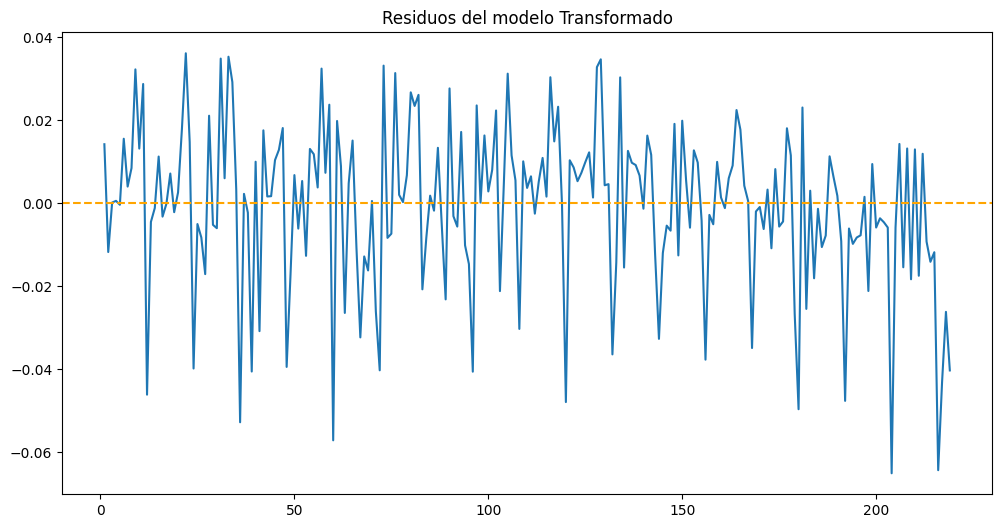

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(resid_full,label="Residuales",)
plt.axhline(y=0, color='orange', linestyle='--')
plt.title('Residuos del modelo Transformado')

Anlizando el gráfico de los residuales, no se observa un patrón aleatorio en los mismos, evidenciando una posible tendencia y heterocedasticidad

####  4.4.2 Validación del supuesto de NO Autocorrelación

#####  4.4.2.1 Prueba de rachas

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [31]:
residuales = resid_full

In [32]:
signo = residuales >0

In [33]:
runstest_1samp(signo, correction=False)

(-1.8666181564285127, 0.06195493025739296)

El segundo valor corresponde al p-valor=0.06, por lo tanto considerando un $α$=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie parece comportarse como un ruido blanco, **No presenta autocorrelación**.

#####  4.4.2.2 Prueba de Box Pierce y Ljung-Box

Este análisis debe complementarse con otras pruebas como la prueba de Box-Pierce y la modificación de Ljung-Box para muestras pequeñas.

In [34]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(residuales, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,1.224364,0.268506,1.207743,0.271779


Con el resultado anterior no rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión Es probar por lo menos los primeros 20 rezagos.

In [35]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuales, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,1.224364,2.685059e-01,1.207743,2.717795e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,1.996516,3.685208e-01,1.965920,3.742018e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,2.956240,3.984214e-01,2.903931,4.066755e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,3.563197,4.683344e-01,3.494409,4.787289e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,4.005459,5.486303e-01,3.922663,5.606036e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,6.312162,3.891450e-01,6.145866,4.070502e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,6.627796,4.686337e-01,6.448645,4.884446e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,7.866039,4.466642e-01,7.630859,4.703333e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,7.938683,5.403372e-01,7.699888,5.646502e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,8.920555,5.396594e-01,8.628446,5.676904e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


El análisis de 20 rezagos, no es concluyente respecto a la "No autocorrelación" de los residuales.  La proporción entre rechazar o no la hipótesis nula, es 50/50

####  4.4.3 Validación del supuesto de homocedasticidad

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

H0:  Comportamiento Homoscedastico (Es decir varianza constante)

H1:  Comportamiento Heteroscedastico (Es decir varianza no constante)

In [36]:
sm.stats.acorr_ljungbox((residuales-residuales.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.200414,6.543869e-01,0.197693,6.565892e-01
2,0.225899,8.931956e-01,0.222718,8.946177e-01
3,2.499936,4.753027e-01,2.445305,4.852568e-01
4,5.477521,2.417125e-01,5.342051,2.539662e-01
5,6.674307,2.460109e-01,6.500930,2.604790e-01
6,7.041005,3.170718e-01,6.854353,3.345269e-01
7,8.796809,2.675755e-01,8.538654,2.874961e-01
8,9.687953,2.876141e-01,9.389475,3.105126e-01
9,9.692095,3.759820e-01,9.393411,4.017794e-01
10,10.662670,3.843957e-01,10.311285,4.136208e-01


Los resultados del la tabla anterior, no son concluyentes, respecto a rechazar on o la hipótesis nula de un comportamiento homocedástico(no auto-correlación de las varianzas).  No se puede concluir por tanto si existe o no tanto comportamiento ARCH o GARCH o heterocedástico.

#### 4.4.4 Prueba de rachas Normalidad

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Nótese que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

#### 4.4.4.1 QQ Plot

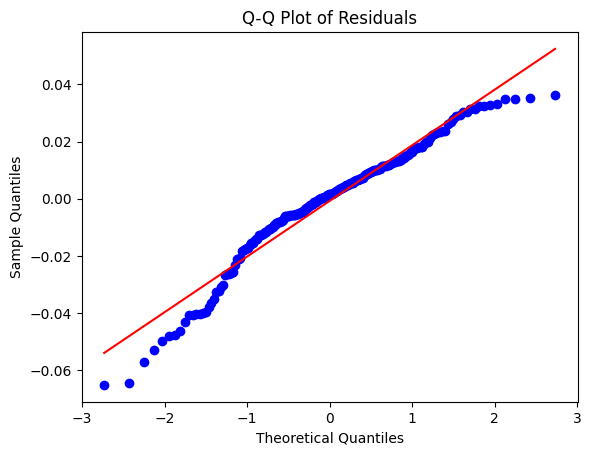

In [37]:
stats.probplot(residuales, dist="norm", plot=plt)
# Añadir etiquetas y título (opcional)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
# Mostrar el gráfico
plt.show()

#### 4.4.4.2 Histograma de residuales

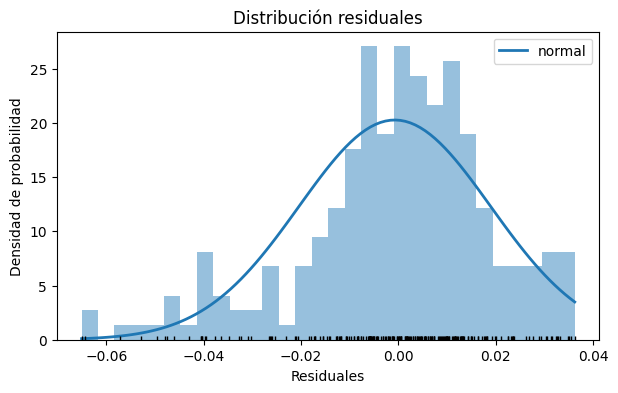

In [38]:
# Histograma + curva normal teórica
# ==============================================================================
# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(residuales)
# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(residuales), max(residuales), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)
# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=residuales, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(residuales, np.full_like(residuales, 0), '|k', markeredgewidth=1)
ax.set_title('Distribución residuales')
ax.set_xlabel('Residuales')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

Según el QQ plot y el histograma, al parecer tenemos una distrubución normal de los residuales

#### 4.4.4.3 Prueba Shapiro y Jarque Bera

In [39]:
stats.shapiro(residuales)

ShapiroResult(statistic=0.9557116031646729, pvalue=2.717210691116634e-06)

In [40]:
stats.jarque_bera(residuales)

SignificanceResult(statistic=27.396229410169948, pvalue=1.124564503689556e-06)

Para ambas pruebas, se rechaza la hipótesis de que los datos provienen de una distribución normal.

# 5. Replicando el modelo sin hacer auto arima, aplicando los mejores hiperparámetros y realizando bootstraping para combatir el problema de no normalidad

In [41]:
model = ARIMA(order=(1,1,1)) #Mejores parámetros
results = model.fit(y_log) #Data set completo en version transformada
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 554.036
Date:                Fri, 23 Aug 2024   AIC                          -1100.072
Time:                        23:40:00   BIC                          -1086.515
Sample:                             0   HQIC                         -1094.597
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      3.286      0.001       0.000       0.001
ar.L1          0.5591      0.114      4.919      0.000       0.336       0.782
ma.L1         -0.8733      0.068    -12.895      0.0

### 5.1. Intervalos de confianza usando boostrap


In [42]:
h= 6 #Horizonte de predicción
res = results.resid() #Contiene los residuos del modelo de regresión ajustado

my_samples = [] # es una lista que almacenará las muestras generadas mediante el método bootstrap.
for _ in range(1000): #Este bucle se ejecuta 1000 veces. El _ es una variable convencionalmente usada en Python cuando el valor de la variable no se necesita dentro del bucle


    x = np.random.choice(res, size=h, replace=True) # Bootstraping: muestreo aleatorio con repetición. Crea una muestra aleatoria de tamaño h a partir del array res. res es el array de residuos del modelo. size=h indica el tamaño de la muestra, en este caso h, que es el horizonte de predicción.replace=True permite el muestreo con reemplazo, es decir, cada elemento puede ser seleccionado más de una vez. Esta línea genera una muestra de tamaño h de residuos, que se usará para estimar la variabilidad de las predicciones del modelo.
    my_samples.append(x) # x es la muestra generada en la iteración actual del bucle.  my_samples es una lista que almacena todas las muestras generadas. Cada muestra es un array de tamaño h.

#Preguntar cómo se forman los cuantiles
q1=np.quantile(my_samples,0.025,axis=0) #q1 calcula el cuantil 0.025 (el límite inferior del intervalo de confianza del 95%) para cada paso en el horizonte de predicción, basado en las muestras bootstrap.
q2=np.quantile(my_samples,0.975,axis=0) #q2 calcula el cuantil 0.975 (el límite superior del intervalo de confianza del 95%) para cada paso en el horizonte de predicción.

fore = results.predict(h,return_conf_int=False) # fore contiene las predicciones del modelo para el horizonte h. Aquí, return_conf_int=False indica que no se están devolviendo intervalos de confianza en esta etapa.


#fore + np.cumsum(q1): Calcula el límite inferior del intervalo de confianza del 95% para cada paso en el horizonte. np.cumsum(q1) calcula la suma acumulativa de los valores en q1, que representa el ajuste a las predicciones puntuales para obtener el límite inferior.
#fore + np.cumsum(q2): Calcula el límite superior del intervalo de confianza del 95% para cada paso en el horizonte. np.cumsum(q2) calcula la suma acumulativa de los valores en q2, que representa el ajuste a las predicciones puntuales para obtener el límite superior.
preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']


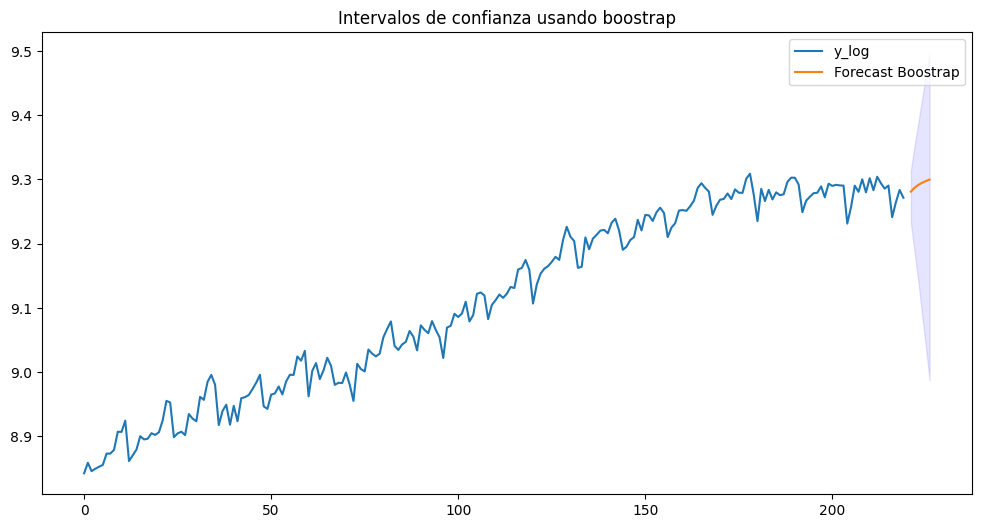

In [43]:
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
fig = plt.figure(figsize=(12, 6))
plt.plot(data.index,y_log,label="y_log")
plt.plot(x_for,preds['Point_forecast'],label="Forecast Boostrap")
plt.fill_between(x_for,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.title('Intervalos de confianza usando boostrap')
plt.legend()
plt.show()

## 5.2 Precciones logarítmicas


In [44]:
preds

,Point_forecast,lower_95,upper_95
0,9.281086,9.232424,9.314144
1,9.287245,9.186559,9.353361
2,9.291559,9.141106,9.388885
3,9.294842,9.089434,9.425226
4,9.297547,9.040115,9.460990
5,9.299931,8.987544,9.496471


## 5.3 Precciones en su escala original


In [45]:
preds_sin_transformar = np.exp(preds)
preds_sin_transformar

,Point_forecast,lower_95,upper_95
0,10733.079597,10223.296521,11093.824097
1,10799.390606,9764.992905,11537.536825
2,10846.080489,9331.080275,11954.767860
3,10881.741510,8861.167289,12397.201350
4,10911.225527,8434.748505,12848.596995
5,10937.262602,8002.776218,13312.665809


## 5.4 Gráfico con datos en su escala original

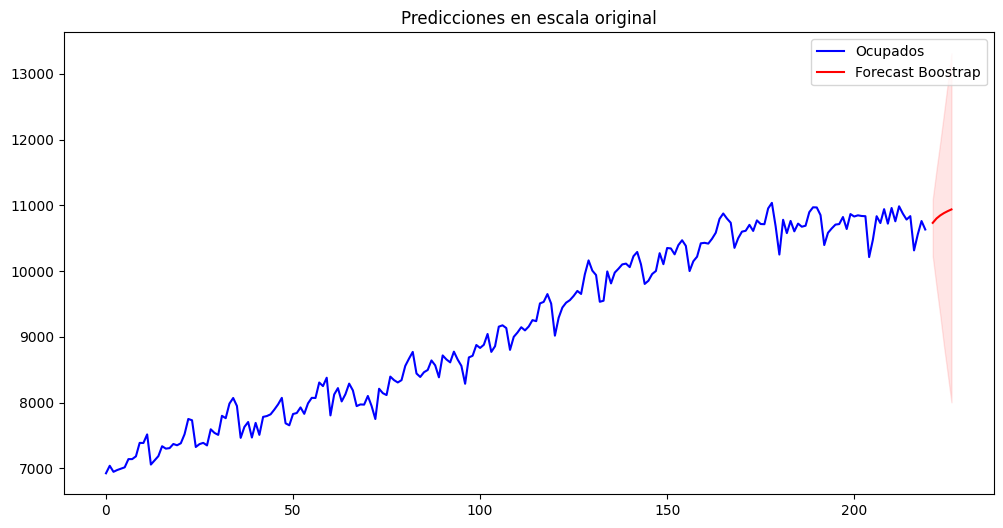

In [46]:
#Graficar el dataframe y en color azul y en la misma grafica incluir preds sin transformar en color rojo al final de la serie
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
fig = plt.figure(figsize=(12, 6))
plt.plot(data.index,data["Ocupados"],label="Ocupados", color='blue')
plt.plot(x_for,preds_sin_transformar['Point_forecast'],label="Forecast Boostrap", color='red')
plt.fill_between(x_for,preds_sin_transformar['lower_95'], preds_sin_transformar['upper_95'], color='red', alpha=0.1)
plt.title('Predicciones en escala original')
plt.legend()
plt.show()